In [1]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.base import TransformerMixin
import numpy as np

from spacy.en import English

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

In [2]:
# loads the datasets and labels
with open('../data/us.text') as f:
    eng_text= f.readlines()
    
with open('../data/us.labels') as f:
    eng_labels = f.readlines()

with open('../data/es.text') as f:
    esp_text = f.readlines()

with open('../data/es.labels') as f:
    esp_labels = f.readlines()

In [3]:
# asserts that the number of tweets and labels are equal
assert len(eng_text) == len(eng_labels)
assert len(esp_text) == len(esp_labels)

In [4]:
# strips the tweets and labels of extra chars
eng_text = [tweet.strip() for tweet in eng_text]
eng_labels = [int(label.strip()) for label in eng_labels]
esp_text = [tweet.strip() for tweet in esp_text]
esp_labels = [int(label.strip()) for label in esp_labels]

In [5]:
print(len(eng_text))
print(len(esp_text))

490265
98683


In [6]:
parser = English()

In [17]:
# tokenizes an input tweet using the spaCy package
def spacy_tokenize(tweet):
    # selected_pos = ['PUNCT', 'VERB', 'ADJ', 'NOUN', 'PROPN', 'ADV']
    tokens = parser(tweet)
    # tokens = [token for token in tokens if (token.pos_ in selected_pos)]  
    tokens = [token.text +'_' + token.pos_ for token in tokens]
    return tokens

In [18]:
spacy_tokenize('I love sushi!')

['I_PRON', 'love_VERB', 'sushi_NOUN', '!_PUNCT']

## Testing word embeddings from spaCy

In [7]:
def spacy_tokenize(sentence):
    tokenized_sent = parser(sentence)
    tokens = []
    for token in tokenized_sent:
        tokens.append(token.text)
    return tokens

In [ ]:
def get_embeddings(word):
    
    # gets word vector for word
    parsed_word = parser.vocab[word]
    print(len(parsed_word))
    
    # gets cosine similarity 
    cosine = lambda v1, v2: dot(v1, v2) / (norm(v1) * norm(v2)) 
    
    # compares to all vocabulary within parser model
    # NOTE TO SELF: filter out named entities and then lowercase?
    all_vocab = list({w for w in parser.vocab if w.has_vector and w.orth_.islower() and w.lower_ != word})
    all_vocab.sort(key=lambda w: cosine(w.vector, parsed_word.vector))
    all_vocab.reverse()
    
    print(len(all_vocab))
    # top 10 similar words
    # most_similar = []
    # for word in all_vocab[:10]:
    #   most_similar.append(word.orth_)
    
    # return most_similar

In [8]:
class Tokenizer(TransformerMixin):
    def transform (self, X, **transform_params):
        return (spacy_tokenize(text) for text in X)
    
    def fit (self, X, y=None, **fit_params):
        return self
    
    def get_params(self, deep=True):
        return {}

In [9]:
from gensim.models.keyedvectors import KeyedVectors
twitter_vectors = KeyedVectors.load_word2vec_format('./glove.twitter.27B.100d.word2vec.txt', binary=False)

In [10]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, twitter_vectors):
        self.twitter_vectors = twitter_vectors
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = 100

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.twitter_vectors[w] for w in words if w in self.twitter_vectors]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [11]:
from collections import defaultdict
class TfIdfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.twitter_vectors = twitter_vectors
        self.word2weight = None
        self.dim = 100

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.twitter_vectors[w] * self.word2weight[w]
                         for w in words if w in self.twitter_vectors] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [13]:
# shuffle the dataset with the same seed
np.random.seed(42)
np.random.shuffle(eng_text)
np.random.seed(42)
np.random.shuffle(eng_labels)
np.random.seed(42)
np.random.shuffle(esp_text)
np.random.seed(42)
np.random.shuffle(esp_labels)

In [12]:
nb = Pipeline([('tokenizer', Tokenizer()), 
               ('w2vTfIdfVectorizer', TfIdfEmbeddingVectorizer(twitter_vectors)),
               ('clf', LinearSVC())])

scores = cross_val_score(nb, eng_text, eng_labels, cv=2, n_jobs=-1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/Users/kennylino/anaconda3/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/Users/kennylino/anaconda3/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x10b2ea030, file "/Use...3.6/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Users/kennylino/.local/share/virtualenvs/emojip...ges/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/Users/kennylino/.local/share/virtualenvs/emojip...lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/Users/kenny.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x10b2ea030, file "/Use...3.6/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Users/kennylino/.local/share/virtualenvs/emojip...ges/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/Users/kennylino/.local/share/virtualenvs/emojip...lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/Users/kenny.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/Users/kennylino/.local/share/virtualenvs/emojiprediction-SvmtXtCx/lib/python3.6/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/Users/kennylino/.local/share/virtualenvs/emojiprediction-SvmtXtCx/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/Users/kennylino/.local/share/virtualenvs/emojiprediction-SvmtXtCx/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    472             return self.subapp.start()
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         try:
--> 477             ioloop.IOLoop.instance().start()
    478         except KeyboardInterrupt:
    479             pass
    480 
    481 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/Users/kennylino/.local/share/virtualenvs/emojiprediction-SvmtXtCx/lib/python3.6/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/Users/kennylino/.local/share/virtualenvs/emojiprediction-SvmtXtCx/lib/python3.6/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
/Users/kennylino/.local/share/virtualenvs/emojiprediction-SvmtXtCx/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/Users/kennylino/.local/share/virtualenvs/emojiprediction-SvmtXtCx/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/Users/kennylino/.local/share/virtualenvs/emojiprediction-SvmtXtCx/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/Users/kennylino/.local/share/virtualenvs/emojiprediction-SvmtXtCx/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/Users/kennylino/.local/share/virtualenvs/emojiprediction-SvmtXtCx/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/Users/kennylino/.local/share/virtualenvs/emojiprediction-SvmtXtCx/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/Users/kennylino/.local/share/virtualenvs/emojiprediction-SvmtXtCx/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'nb = Pipeline([(\'tokenizer\', Tokenizer()), \n    ...(+/- %0.2f)" % (scores.mean(), scores.std() * 2))', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 1, 8, 11, 26, 3, 795558, tzinfo=tzutc()), 'msg_id': '00EA3EFB8DB043D5AB976B483B946287', 'msg_type': 'execute_request', 'session': '648836885BD44B878F7141B94CB761B1', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '00EA3EFB8DB043D5AB976B483B946287', 'msg_type': 'execute_request', 'parent_header': {}})
    230             self.log.warn("Unknown message type: %r", msg_type)
    231         else:
    232             self.log.debug("%s: %s", msg_type, msg)
    233             self.pre_handler_hook()
    234             try:
--> 235                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'648836885BD44B878F7141B94CB761B1']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'nb = Pipeline([(\'tokenizer\', Tokenizer()), \n    ...(+/- %0.2f)" % (scores.mean(), scores.std() * 2))', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 1, 8, 11, 26, 3, 795558, tzinfo=tzutc()), 'msg_id': '00EA3EFB8DB043D5AB976B483B946287', 'msg_type': 'execute_request', 'session': '648836885BD44B878F7141B94CB761B1', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '00EA3EFB8DB043D5AB976B483B946287', 'msg_type': 'execute_request', 'parent_header': {}}
    236             except Exception:
    237                 self.log.error("Exception in message handler:", exc_info=True)
    238             finally:
    239                 self.post_handler_hook()

...........................................................................
/Users/kennylino/.local/share/virtualenvs/emojiprediction-SvmtXtCx/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'648836885BD44B878F7141B94CB761B1'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'nb = Pipeline([(\'tokenizer\', Tokenizer()), \n    ...(+/- %0.2f)" % (scores.mean(), scores.std() * 2))', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 1, 8, 11, 26, 3, 795558, tzinfo=tzutc()), 'msg_id': '00EA3EFB8DB043D5AB976B483B946287', 'msg_type': 'execute_request', 'session': '648836885BD44B878F7141B94CB761B1', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '00EA3EFB8DB043D5AB976B483B946287', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/Users/kennylino/.local/share/virtualenvs/emojiprediction-SvmtXtCx/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='nb = Pipeline([(\'tokenizer\', Tokenizer()), \n    ...(+/- %0.2f)" % (scores.mean(), scores.std() * 2))', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'nb = Pipeline([(\'tokenizer\', Tokenizer()), \n    ...(+/- %0.2f)" % (scores.mean(), scores.std() * 2))'
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
/Users/kennylino/.local/share/virtualenvs/emojiprediction-SvmtXtCx/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('nb = Pipeline([(\'tokenizer\', Tokenizer()), \n    ...(+/- %0.2f)" % (scores.mean(), scores.std() * 2))',), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('nb = Pipeline([(\'tokenizer\', Tokenizer()), \n    ...(+/- %0.2f)" % (scores.mean(), scores.std() * 2))',)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
/Users/kennylino/.local/share/virtualenvs/emojiprediction-SvmtXtCx/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='nb = Pipeline([(\'tokenizer\', Tokenizer()), \n    ...(+/- %0.2f)" % (scores.mean(), scores.std() * 2))', store_history=True, silent=False, shell_futures=True)
   2723                 self.displayhook.exec_result = result
   2724 
   2725                 # Execute the user code
   2726                 interactivity = "none" if silent else self.ast_node_interactivity
   2727                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2728                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2729                 
   2730                 self.last_execution_succeeded = not has_raised
   2731                 self.last_execution_result = result
   2732 

...........................................................................
/Users/kennylino/.local/share/virtualenvs/emojiprediction-SvmtXtCx/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Assign object>, <_ast.Expr object>], cell_name='<ipython-input-12-ead1351126f6>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 18b631128, execution_..._before_exec=None error_in_exec=None result=None>)
   2845 
   2846         try:
   2847             for i, node in enumerate(to_run_exec):
   2848                 mod = ast.Module([node])
   2849                 code = compiler(mod, cell_name, "exec")
-> 2850                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x18b619c90, file "<ipython-input-12-ead1351126f6>", line 5>
        result = <ExecutionResult object at 18b631128, execution_..._before_exec=None error_in_exec=None result=None>
   2851                     return True
   2852 
   2853             for i, node in enumerate(to_run_interactive):
   2854                 mod = ast.Interactive([node])

...........................................................................
/Users/kennylino/.local/share/virtualenvs/emojiprediction-SvmtXtCx/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x18b619c90, file "<ipython-input-12-ead1351126f6>", line 5>, result=<ExecutionResult object at 18b631128, execution_..._before_exec=None error_in_exec=None result=None>)
   2905         outflag = True  # happens in more places, so it's easier as default
   2906         try:
   2907             try:
   2908                 self.hooks.pre_run_code_hook()
   2909                 #rprint('Running code', repr(code_obj)) # dbg
-> 2910                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x18b619c90, file "<ipython-input-12-ead1351126f6>", line 5>
        self.user_global_ns = {'English': <class 'spacy.en.English'>, 'GaussianNB': <class 'sklearn.naive_bayes.GaussianNB'>, 'In': ['', "from sklearn.pipeline import Pipeline\nfrom sklea..._ipython().run_line_magic('matplotlib', 'inline')", "# loads the datasets and labels\nwith open('../da.../es.labels') as f:\n    esp_labels = f.readlines()", '# asserts that the number of tweets and labels a...g_labels)\nassert len(esp_text) == len(esp_labels)', '# strips the tweets and labels of extra chars\nen...ls = [int(label.strip()) for label in esp_labels]', 'print(len(eng_text))\nprint(len(esp_text))', 'parser = English()', 'def spacy_tokenize(sentence):\n    tokenized_sent...      tokens.append(token.text)\n    return tokens', 'class Tokenizer(TransformerMixin):\n    def trans...ef get_params(self, deep=True):\n        return {}', "from gensim.models.keyedvectors import KeyedVect...ove.twitter.27B.100d.word2vec.txt', binary=False)", 'class MeanEmbeddingVectorizer(object):\n    def _...)], axis=0)\n            for words in X\n        ])', 'from collections import defaultdict\nclass TfIdfE...=0)\n                for words in X\n            ])', 'nb = Pipeline([(\'tokenizer\', Tokenizer()), \n    ...(+/- %0.2f)" % (scores.mean(), scores.std() * 2))'], 'KeyedVectors': <class 'gensim.models.keyedvectors.EuclideanKeyedVectors'>, 'LinearSVC': <class 'sklearn.svm.classes.LinearSVC'>, 'MeanEmbeddingVectorizer': <class '__main__.MeanEmbeddingVectorizer'>, 'MultinomialNB': <class 'sklearn.naive_bayes.MultinomialNB'>, 'Out': {}, 'Pipeline': <class 'sklearn.pipeline.Pipeline'>, 'TfIdfEmbeddingVectorizer': <class '__main__.TfIdfEmbeddingVectorizer'>, ...}
        self.user_ns = {'English': <class 'spacy.en.English'>, 'GaussianNB': <class 'sklearn.naive_bayes.GaussianNB'>, 'In': ['', "from sklearn.pipeline import Pipeline\nfrom sklea..._ipython().run_line_magic('matplotlib', 'inline')", "# loads the datasets and labels\nwith open('../da.../es.labels') as f:\n    esp_labels = f.readlines()", '# asserts that the number of tweets and labels a...g_labels)\nassert len(esp_text) == len(esp_labels)', '# strips the tweets and labels of extra chars\nen...ls = [int(label.strip()) for label in esp_labels]', 'print(len(eng_text))\nprint(len(esp_text))', 'parser = English()', 'def spacy_tokenize(sentence):\n    tokenized_sent...      tokens.append(token.text)\n    return tokens', 'class Tokenizer(TransformerMixin):\n    def trans...ef get_params(self, deep=True):\n        return {}', "from gensim.models.keyedvectors import KeyedVect...ove.twitter.27B.100d.word2vec.txt', binary=False)", 'class MeanEmbeddingVectorizer(object):\n    def _...)], axis=0)\n            for words in X\n        ])', 'from collections import defaultdict\nclass TfIdfE...=0)\n                for words in X\n            ])', 'nb = Pipeline([(\'tokenizer\', Tokenizer()), \n    ...(+/- %0.2f)" % (scores.mean(), scores.std() * 2))'], 'KeyedVectors': <class 'gensim.models.keyedvectors.EuclideanKeyedVectors'>, 'LinearSVC': <class 'sklearn.svm.classes.LinearSVC'>, 'MeanEmbeddingVectorizer': <class '__main__.MeanEmbeddingVectorizer'>, 'MultinomialNB': <class 'sklearn.naive_bayes.MultinomialNB'>, 'Out': {}, 'Pipeline': <class 'sklearn.pipeline.Pipeline'>, 'TfIdfEmbeddingVectorizer': <class '__main__.TfIdfEmbeddingVectorizer'>, ...}
   2911             finally:
   2912                 # Reset our crash handler in place
   2913                 sys.excepthook = old_excepthook
   2914         except SystemExit as e:

...........................................................................
/Users/kennylino/Documents/EM LCT Courses/UoM Courses/Applied Machine Learning/emojiprediction/<ipython-input-12-ead1351126f6> in <module>()
      1 nb = Pipeline([('tokenizer', Tokenizer()), 
      2                ('w2vTfIdfVectorizer', TfIdfEmbeddingVectorizer(twitter_vectors)),
      3                ('clf', LinearSVC())])
      4 
----> 5 scores = cross_val_score(nb, eng_text, eng_labels, cv=2, n_jobs=-1)
      6 print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

...........................................................................
/Users/kennylino/.local/share/virtualenvs/emojiprediction-SvmtXtCx/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in cross_val_score(estimator=Pipeline(memory=None,
     steps=[('tokenizer', ...random_state=None, tol=0.0001,
     verbose=0))]), X=['LoL @ West Covina, California', 'Things got a little festive at the office #christmas2016 @ RedRock…', 'Step out and explore. # ️ @ Ellis Island Cafe', '@user @ Cathedral Preparatory School', "My baby bear @ Bubby's", "RuPaul's Drag Race bingo fun. Drag Queens be SEXY! #rupaulsdragrace @user abwyman #la…", 'Black History like a Mufffffaaaaaka #blacchyna done thru her yugioh trap card like hell …', 'Just light makeup ️ #blueeyes #lupusgirl #photography #modelingagency #modeling #smiling…', "@ BJ's Restaurant and Brewhouse", 'So lovely catching up with my soul sister @user @ University of Victoria', 'Perfect for this weather ️ #dessert #snowice #snowwhite #lasvegas #summer @ Snow White Cafe', 'Had fun (at @user in New York, NY)', 'Well Damn @ Oklahoma City, Oklahoma', "'scuse me while I kiss the sky. ___ : nikkileekv @ Malibu, California", 'Fun in the sun ️ @ Brownstone Park, Portland, CT', 'Celebrating #LAstyle @ Calle Tacos', 'I think today is about to be a great day..', "@user it's all Bama now What's your take on Kiffin? Ask a #Bama fan.", "Bae-rito Wednesday. the day we convinced the girl that's addicted…", 'Birthday Ski Trip with ny sweet hubby! #OneYearAwayFrom30 #BirthdaySkiTrip #SteamboatSprings…', ...], y=[2, 17, 0, 18, 1, 9, 2, 0, 8, 13, 0, 1, 2, 18, 12, 3, 5, 14, 16, 1, ...], groups=None, scoring=None, cv=2, n_jobs=-1, verbose=0, fit_params=None, pre_dispatch='2*n_jobs')
    337     cv_results = cross_validate(estimator=estimator, X=X, y=y, groups=groups,
    338                                 scoring={'score': scorer}, cv=cv,
    339                                 return_train_score=False,
    340                                 n_jobs=n_jobs, verbose=verbose,
    341                                 fit_params=fit_params,
--> 342                                 pre_dispatch=pre_dispatch)
        pre_dispatch = '2*n_jobs'
    343     return cv_results['test_score']
    344 
    345 
    346 def _fit_and_score(estimator, X, y, scorer, train, test, verbose,

...........................................................................
/Users/kennylino/.local/share/virtualenvs/emojiprediction-SvmtXtCx/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in cross_validate(estimator=Pipeline(memory=None,
     steps=[('tokenizer', ...random_state=None, tol=0.0001,
     verbose=0))]), X=['LoL @ West Covina, California', 'Things got a little festive at the office #christmas2016 @ RedRock…', 'Step out and explore. # ️ @ Ellis Island Cafe', '@user @ Cathedral Preparatory School', "My baby bear @ Bubby's", "RuPaul's Drag Race bingo fun. Drag Queens be SEXY! #rupaulsdragrace @user abwyman #la…", 'Black History like a Mufffffaaaaaka #blacchyna done thru her yugioh trap card like hell …', 'Just light makeup ️ #blueeyes #lupusgirl #photography #modelingagency #modeling #smiling…', "@ BJ's Restaurant and Brewhouse", 'So lovely catching up with my soul sister @user @ University of Victoria', 'Perfect for this weather ️ #dessert #snowice #snowwhite #lasvegas #summer @ Snow White Cafe', 'Had fun (at @user in New York, NY)', 'Well Damn @ Oklahoma City, Oklahoma', "'scuse me while I kiss the sky. ___ : nikkileekv @ Malibu, California", 'Fun in the sun ️ @ Brownstone Park, Portland, CT', 'Celebrating #LAstyle @ Calle Tacos', 'I think today is about to be a great day..', "@user it's all Bama now What's your take on Kiffin? Ask a #Bama fan.", "Bae-rito Wednesday. the day we convinced the girl that's addicted…", 'Birthday Ski Trip with ny sweet hubby! #OneYearAwayFrom30 #BirthdaySkiTrip #SteamboatSprings…', ...], y=[2, 17, 0, 18, 1, 9, 2, 0, 8, 13, 0, 1, 2, 18, 12, 3, 5, 14, 16, 1, ...], groups=None, scoring={'score': <function _passthrough_scorer>}, cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False), n_jobs=-1, verbose=0, fit_params=None, pre_dispatch='2*n_jobs', return_train_score=False)
    201     scores = parallel(
    202         delayed(_fit_and_score)(
    203             clone(estimator), X, y, scorers, train, test, verbose, None,
    204             fit_params, return_train_score=return_train_score,
    205             return_times=True)
--> 206         for train, test in cv.split(X, y, groups))
        cv.split = <bound method StratifiedKFold.split of Stratifie...ld(n_splits=2, random_state=None, shuffle=False)>
        X = ['LoL @ West Covina, California', 'Things got a little festive at the office #christmas2016 @ RedRock…', 'Step out and explore. # ️ @ Ellis Island Cafe', '@user @ Cathedral Preparatory School', "My baby bear @ Bubby's", "RuPaul's Drag Race bingo fun. Drag Queens be SEXY! #rupaulsdragrace @user abwyman #la…", 'Black History like a Mufffffaaaaaka #blacchyna done thru her yugioh trap card like hell …', 'Just light makeup ️ #blueeyes #lupusgirl #photography #modelingagency #modeling #smiling…', "@ BJ's Restaurant and Brewhouse", 'So lovely catching up with my soul sister @user @ University of Victoria', 'Perfect for this weather ️ #dessert #snowice #snowwhite #lasvegas #summer @ Snow White Cafe', 'Had fun (at @user in New York, NY)', 'Well Damn @ Oklahoma City, Oklahoma', "'scuse me while I kiss the sky. ___ : nikkileekv @ Malibu, California", 'Fun in the sun ️ @ Brownstone Park, Portland, CT', 'Celebrating #LAstyle @ Calle Tacos', 'I think today is about to be a great day..', "@user it's all Bama now What's your take on Kiffin? Ask a #Bama fan.", "Bae-rito Wednesday. the day we convinced the girl that's addicted…", 'Birthday Ski Trip with ny sweet hubby! #OneYearAwayFrom30 #BirthdaySkiTrip #SteamboatSprings…', ...]
        y = [2, 17, 0, 18, 1, 9, 2, 0, 8, 13, 0, 1, 2, 18, 12, 3, 5, 14, 16, 1, ...]
        groups = None
    207 
    208     if return_train_score:
    209         train_scores, test_scores, fit_times, score_times = zip(*scores)
    210         train_scores = _aggregate_score_dicts(train_scores)

...........................................................................
/Users/kennylino/.local/share/virtualenvs/emojiprediction-SvmtXtCx/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object cross_validate.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Mon Jan  8 12:34:35 2018
PID: 2868Python 3.6.3: /Users/kennylino/.local/share/virtualenvs/emojiprediction-SvmtXtCx/bin/python
...........................................................................
/Users/kennylino/.local/share/virtualenvs/emojiprediction-SvmtXtCx/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (Pipeline(memory=None,
     steps=[('tokenizer', ...random_state=None, tol=0.0001,
     verbose=0))]), ['LoL @ West Covina, California', 'Things got a little festive at the office #christmas2016 @ RedRock…', 'Step out and explore. # ️ @ Ellis Island Cafe', '@user @ Cathedral Preparatory School', "My baby bear @ Bubby's", "RuPaul's Drag Race bingo fun. Drag Queens be SEXY! #rupaulsdragrace @user abwyman #la…", 'Black History like a Mufffffaaaaaka #blacchyna done thru her yugioh trap card like hell …', 'Just light makeup ️ #blueeyes #lupusgirl #photography #modelingagency #modeling #smiling…', "@ BJ's Restaurant and Brewhouse", 'So lovely catching up with my soul sister @user @ University of Victoria', 'Perfect for this weather ️ #dessert #snowice #snowwhite #lasvegas #summer @ Snow White Cafe', 'Had fun (at @user in New York, NY)', 'Well Damn @ Oklahoma City, Oklahoma', "'scuse me while I kiss the sky. ___ : nikkileekv @ Malibu, California", 'Fun in the sun ️ @ Brownstone Park, Portland, CT', 'Celebrating #LAstyle @ Calle Tacos', 'I think today is about to be a great day..', "@user it's all Bama now What's your take on Kiffin? Ask a #Bama fan.", "Bae-rito Wednesday. the day we convinced the girl that's addicted…", 'Birthday Ski Trip with ny sweet hubby! #OneYearAwayFrom30 #BirthdaySkiTrip #SteamboatSprings…', ...], [2, 17, 0, 18, 1, 9, 2, 0, 8, 13, 0, 1, 2, 18, 12, 3, 5, 14, 16, 1, ...], {'score': <function _passthrough_scorer>}, memmap([241494, 241497, 241520, ..., 490262, 490263, 490264]), memmap([     0,      1,      2, ..., 248821, 248827, 248830]), 0, None, None), {'return_times': True, 'return_train_score': False})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Users/kennylino/.local/share/virtualenvs/emojiprediction-SvmtXtCx/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (Pipeline(memory=None,
     steps=[('tokenizer', ...random_state=None, tol=0.0001,
     verbose=0))]), ['LoL @ West Covina, California', 'Things got a little festive at the office #christmas2016 @ RedRock…', 'Step out and explore. # ️ @ Ellis Island Cafe', '@user @ Cathedral Preparatory School', "My baby bear @ Bubby's", "RuPaul's Drag Race bingo fun. Drag Queens be SEXY! #rupaulsdragrace @user abwyman #la…", 'Black History like a Mufffffaaaaaka #blacchyna done thru her yugioh trap card like hell …', 'Just light makeup ️ #blueeyes #lupusgirl #photography #modelingagency #modeling #smiling…', "@ BJ's Restaurant and Brewhouse", 'So lovely catching up with my soul sister @user @ University of Victoria', 'Perfect for this weather ️ #dessert #snowice #snowwhite #lasvegas #summer @ Snow White Cafe', 'Had fun (at @user in New York, NY)', 'Well Damn @ Oklahoma City, Oklahoma', "'scuse me while I kiss the sky. ___ : nikkileekv @ Malibu, California", 'Fun in the sun ️ @ Brownstone Park, Portland, CT', 'Celebrating #LAstyle @ Calle Tacos', 'I think today is about to be a great day..', "@user it's all Bama now What's your take on Kiffin? Ask a #Bama fan.", "Bae-rito Wednesday. the day we convinced the girl that's addicted…", 'Birthday Ski Trip with ny sweet hubby! #OneYearAwayFrom30 #BirthdaySkiTrip #SteamboatSprings…', ...], [2, 17, 0, 18, 1, 9, 2, 0, 8, 13, 0, 1, 2, 18, 12, 3, 5, 14, 16, 1, ...], {'score': <function _passthrough_scorer>}, memmap([241494, 241497, 241520, ..., 490262, 490263, 490264]), memmap([     0,      1,      2, ..., 248821, 248827, 248830]), 0, None, None)
        kwargs = {'return_times': True, 'return_train_score': False}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Users/kennylino/.local/share/virtualenvs/emojiprediction-SvmtXtCx/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=Pipeline(memory=None,
     steps=[('tokenizer', ...random_state=None, tol=0.0001,
     verbose=0))]), X=['LoL @ West Covina, California', 'Things got a little festive at the office #christmas2016 @ RedRock…', 'Step out and explore. # ️ @ Ellis Island Cafe', '@user @ Cathedral Preparatory School', "My baby bear @ Bubby's", "RuPaul's Drag Race bingo fun. Drag Queens be SEXY! #rupaulsdragrace @user abwyman #la…", 'Black History like a Mufffffaaaaaka #blacchyna done thru her yugioh trap card like hell …', 'Just light makeup ️ #blueeyes #lupusgirl #photography #modelingagency #modeling #smiling…', "@ BJ's Restaurant and Brewhouse", 'So lovely catching up with my soul sister @user @ University of Victoria', 'Perfect for this weather ️ #dessert #snowice #snowwhite #lasvegas #summer @ Snow White Cafe', 'Had fun (at @user in New York, NY)', 'Well Damn @ Oklahoma City, Oklahoma', "'scuse me while I kiss the sky. ___ : nikkileekv @ Malibu, California", 'Fun in the sun ️ @ Brownstone Park, Portland, CT', 'Celebrating #LAstyle @ Calle Tacos', 'I think today is about to be a great day..', "@user it's all Bama now What's your take on Kiffin? Ask a #Bama fan.", "Bae-rito Wednesday. the day we convinced the girl that's addicted…", 'Birthday Ski Trip with ny sweet hubby! #OneYearAwayFrom30 #BirthdaySkiTrip #SteamboatSprings…', ...], y=[2, 17, 0, 18, 1, 9, 2, 0, 8, 13, 0, 1, 2, 18, 12, 3, 5, 14, 16, 1, ...], scorer={'score': <function _passthrough_scorer>}, train=memmap([241494, 241497, 241520, ..., 490262, 490263, 490264]), test=memmap([     0,      1,      2, ..., 248821, 248827, 248830]), verbose=0, parameters=None, fit_params={}, return_train_score=False, return_parameters=False, return_n_test_samples=False, return_times=True, error_score='raise')
    453 
    454     try:
    455         if y_train is None:
    456             estimator.fit(X_train, **fit_params)
    457         else:
--> 458             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method Pipeline.fit of Pipeline(memory=No...andom_state=None, tol=0.0001,
     verbose=0))])>
        X_train = ['FISH. TACOS. #Merica #foodporn @ Miller Ale House', '{TRAVELS} Our little Good Luck four leaf clover bracelet amongst the majestic redwood trees…', 'Hooray for the Red, White, and (lemon) Blue(berry)!! Happy 4th of July weekend...come…', 'Show time #lasvegas @ Bellagio Las Vegas', '@ Hampton Inn &amp; Suites - Orange Beach', 'Our first vote as a household, and we voted for her and for our future! :) #NYCvotes…', 'Found my spot! ....#ny #nyc #centralpark #igaddict #insta #instagramers #instagramer…', 'You a bad girl &amp; your friends bad too @ Golden Nugget Hotel &amp; Casino', '2nd day in Universal Florida #Orlando #usa #usa #vacances2016 @user', 'Thanking all the men and women who serve and their families. #freebecauseofthebrave #thankyou…', 'BEGGINERS LUCK I GUESS .... I guess it was my night #casino #SLS…', 'Chopin by Ingolf Wunder!!! (@ Bennett-Gordon Hall in Highland Park, IL w/ @user', '#vote @ Delaware County, Pennsylvania', 'The preparations for the ST Mastery clinic in the US are in full swing at Narnia Stables, the…', "6 weeks post ankle reconstruction and look what I can do! I haven't been able to walk up and…", "We didn't get stickers but our votes still count! @ Locust Lane Pool", 'I could be in school right now, but instead #WelcomeToHollywood @ Hollywood Blvd.', '#GiraUsa2016 @ New York Public Library', 'HAPPY #MemorialDay all our #Veterans &amp; current #Military #NaturalSinceBirth…', 'Thinking of a masterplan ... @ Minervas Downtown Sioux Falls', ...]
        y_train = [11, 11, 11, 11, 19, 11, 19, 19, 11, 11, 19, 19, 11, 11, 19, 11, 19, 11, 11, 19, ...]
        fit_params = {}
    459 
    460     except Exception as e:
    461         # Note fit time as time until error
    462         fit_time = time.time() - start_time

...........................................................................
/Users/kennylino/.local/share/virtualenvs/emojiprediction-SvmtXtCx/lib/python3.6/site-packages/sklearn/pipeline.py in fit(self=Pipeline(memory=None,
     steps=[('tokenizer', ...random_state=None, tol=0.0001,
     verbose=0))]), X=['FISH. TACOS. #Merica #foodporn @ Miller Ale House', '{TRAVELS} Our little Good Luck four leaf clover bracelet amongst the majestic redwood trees…', 'Hooray for the Red, White, and (lemon) Blue(berry)!! Happy 4th of July weekend...come…', 'Show time #lasvegas @ Bellagio Las Vegas', '@ Hampton Inn &amp; Suites - Orange Beach', 'Our first vote as a household, and we voted for her and for our future! :) #NYCvotes…', 'Found my spot! ....#ny #nyc #centralpark #igaddict #insta #instagramers #instagramer…', 'You a bad girl &amp; your friends bad too @ Golden Nugget Hotel &amp; Casino', '2nd day in Universal Florida #Orlando #usa #usa #vacances2016 @user', 'Thanking all the men and women who serve and their families. #freebecauseofthebrave #thankyou…', 'BEGGINERS LUCK I GUESS .... I guess it was my night #casino #SLS…', 'Chopin by Ingolf Wunder!!! (@ Bennett-Gordon Hall in Highland Park, IL w/ @user', '#vote @ Delaware County, Pennsylvania', 'The preparations for the ST Mastery clinic in the US are in full swing at Narnia Stables, the…', "6 weeks post ankle reconstruction and look what I can do! I haven't been able to walk up and…", "We didn't get stickers but our votes still count! @ Locust Lane Pool", 'I could be in school right now, but instead #WelcomeToHollywood @ Hollywood Blvd.', '#GiraUsa2016 @ New York Public Library', 'HAPPY #MemorialDay all our #Veterans &amp; current #Military #NaturalSinceBirth…', 'Thinking of a masterplan ... @ Minervas Downtown Sioux Falls', ...], y=[11, 11, 11, 11, 19, 11, 19, 19, 11, 11, 19, 19, 11, 11, 19, 11, 19, 11, 11, 19, ...], **fit_params={})
    245         self : Pipeline
    246             This estimator
    247         """
    248         Xt, fit_params = self._fit(X, y, **fit_params)
    249         if self._final_estimator is not None:
--> 250             self._final_estimator.fit(Xt, y, **fit_params)
        self._final_estimator.fit = <bound method LinearSVC.fit of LinearSVC(C=1.0, ..., random_state=None, tol=0.0001,
     verbose=0)>
        Xt = array([], dtype=float64)
        y = [11, 11, 11, 11, 19, 11, 19, 19, 11, 11, 19, 19, 11, 11, 19, 11, 19, 11, 11, 19, ...]
        fit_params = {}
    251         return self
    252 
    253     def fit_transform(self, X, y=None, **fit_params):
    254         """Fit the model and transform with the final estimator

...........................................................................
/Users/kennylino/.local/share/virtualenvs/emojiprediction-SvmtXtCx/lib/python3.6/site-packages/sklearn/svm/classes.py in fit(self=LinearSVC(C=1.0, class_weight=None, dual=True, f...', random_state=None, tol=0.0001,
     verbose=0), X=array([], dtype=float64), y=[11, 11, 11, 11, 19, 11, 19, 19, 11, 11, 19, 19, 11, 11, 19, 11, 19, 11, 11, 19, ...], sample_weight=None)
    222         if self.C < 0:
    223             raise ValueError("Penalty term must be positive; got (C=%r)"
    224                              % self.C)
    225 
    226         X, y = check_X_y(X, y, accept_sparse='csr',
--> 227                          dtype=np.float64, order="C")
    228         check_classification_targets(y)
    229         self.classes_ = np.unique(y)
    230 
    231         self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(

...........................................................................
/Users/kennylino/.local/share/virtualenvs/emojiprediction-SvmtXtCx/lib/python3.6/site-packages/sklearn/utils/validation.py in check_X_y(X=array([], dtype=float64), y=[11, 11, 11, 11, 19, 11, 19, 19, 11, 11, 19, 19, 11, 11, 19, 11, 19, 11, 11, 19, ...], accept_sparse='csr', dtype=<class 'numpy.float64'>, order='C', copy=False, force_all_finite=True, ensure_2d=True, allow_nd=False, multi_output=False, ensure_min_samples=1, ensure_min_features=1, y_numeric=False, warn_on_dtype=False, estimator=None)
    568     y_converted : object
    569         The converted and validated y.
    570     """
    571     X = check_array(X, accept_sparse, dtype, order, copy, force_all_finite,
    572                     ensure_2d, allow_nd, ensure_min_samples,
--> 573                     ensure_min_features, warn_on_dtype, estimator)
        ensure_min_features = 1
        warn_on_dtype = False
        estimator = None
    574     if multi_output:
    575         y = check_array(y, 'csr', force_all_finite=True, ensure_2d=False,
    576                         dtype=None)
    577     else:

...........................................................................
/Users/kennylino/.local/share/virtualenvs/emojiprediction-SvmtXtCx/lib/python3.6/site-packages/sklearn/utils/validation.py in check_array(array=array([], dtype=float64), accept_sparse='csr', dtype=<class 'numpy.float64'>, order='C', copy=False, force_all_finite=True, ensure_2d=True, allow_nd=False, ensure_min_samples=1, ensure_min_features=1, warn_on_dtype=False, estimator=None)
    436             if array.ndim == 1:
    437                 raise ValueError(
    438                     "Expected 2D array, got 1D array instead:\narray={}.\n"
    439                     "Reshape your data either using array.reshape(-1, 1) if "
    440                     "your data has a single feature or array.reshape(1, -1) "
--> 441                     "if it contains a single sample.".format(array))
        array = array([], dtype=float64)
    442             array = np.atleast_2d(array)
    443             # To ensure that array flags are maintained
    444             array = np.array(array, dtype=dtype, order=order, copy=copy)
    445 

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
___________________________________________________________________________

## English Naive-Bayes Model

In [29]:
pipe = Pipeline([('tfidf', TfidfVectorizer(tokenizer=spacy_tokenize)),
                 ('clf', MultinomialNB())])

In [24]:
pipe = Pipeline([('tfidf', TfidfVectorizer()),
                 ('clf', MultinomialNB())])

scores = cross_val_score(pipe, eng_text, eng_labels, cv=5, n_jobs=-1)
# n_jobs uses all the cores for faster validation

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Process ForkPoolWorker-32:
Process ForkPoolWorker-31:
Process ForkPoolWorker-30:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/kennylino/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/kennylino/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/kennylino/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()


KeyboardInterrupt: 

In [20]:
print(scores)

[ 0.24538307  0.24633898  0.24550739  0.24614475  0.2458386 ]


### English Naive-Bayes Confusion Matrix

In [26]:
y_pred = cross_val_predict(pipe,eng_text,eng_labels,cv=5, n_jobs=-1)
conf_mat = confusion_matrix(eng_labels,y_pred)
print(conf_mat)

[[105209    408    795      1     20      0      2      1      0      0
       0     21      2      0      0      0      0      7      0      0]
 [ 49208   1252    827      1     25      0      0      1      0      0
       1      9      0      0      0      0      0      3      0      0]
 [ 37557    133  12673      0     47      0      0      0      1      0
       0     23      1      0      0      1      0      1      0      0]
 [ 26767    101    182     11      4      0      0      0      1      0
       0      0      0      0      0      0      0      1      0      0]
 [ 20886    189   1837      0   1500      0      0      0      1      0
       1     10      0      0      0      0      0      1      1      0]
 [ 22240    136    714      0      6      6      0      0      0      0
       0      8      0      0      0      0      0      2      0      0]
 [ 19911    103   1042      0     42      0     14      0      0      0
       0      6      0      0      0      0      0      0 

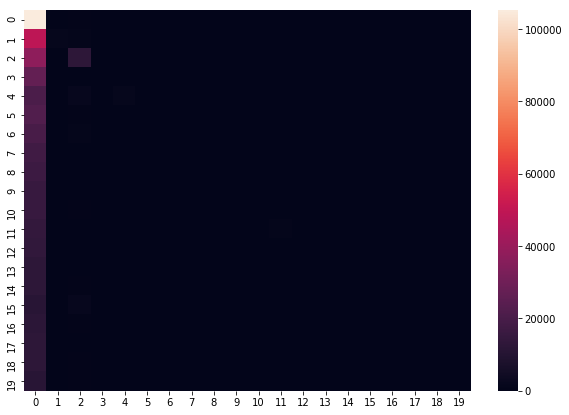

In [27]:
df_cm = pd.DataFrame(conf_mat, index = [i for i in set(eng_labels)], columns = [i for i in set(eng_labels)])
plt.figure(figsize= (10,7))
sn.heatmap(df_cm, annot=False)

In [ ]:
set(eng_labels)

In [28]:
print(classification_report(eng_labels, y_pred))

             precision    recall  f1-score   support

          0       0.23      0.99      0.37    106466
          1       0.40      0.02      0.05     51327
          2       0.52      0.25      0.34     50437
          3       0.69      0.00      0.00     27067
          4       0.79      0.06      0.11     24426
          5       1.00      0.00      0.00     23112
          6       0.74      0.00      0.00     21118
          7       0.88      0.00      0.00     18162
          8       0.89      0.00      0.00     16846
          9       0.00      0.00      0.00     15985
         10       0.88      0.00      0.01     15947
         11       0.88      0.06      0.11     15182
         12       0.83      0.00      0.00     13717
         13       0.75      0.00      0.00     12839
         14       0.00      0.00      0.00     13359
         15       0.96      0.00      0.00     13264
         16       0.00      0.00      0.00     12958
         17       0.89      0.01      0.03   

/Users/kennylino/.local/share/virtualenvs/emojiprediction-SvmtXtCx/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Spanish Naive-Bayes Model

In [ ]:
pipe = Pipeline([('tfidf', TfidfVectorizer()),
                 ('clf', MultinomialNB())])

scores = cross_val_score(pipe, esp_text, esp_labels, cv=20, n_jobs=-1)
# n_jobs uses all the cores for faster validation

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [ ]:
print(scores)

### Spanish Naive-Bayes Confusion Matrix

In [ ]:
y_pred = cross_val_predict(pipe,esp_text,esp_labels,cv=5, n_jobs=-1)
conf_mat= confusion_matrix(esp_labels,y_pred)
print(conf_mat)

In [ ]:
df_cm = pd.DataFrame(conf_mat, index = [i for i in set(esp_labels)], columns = [i for i in set(esp_labels)])
plt.figure(figsize= (10,7))
sn.heatmap(df_cm, annot=False)

In [ ]:
print(classification_report(esp_labels, y_pred))

## English Support Vector Machine Model

In [35]:
pipe = Pipeline([('tfidf', TfidfVectorizer(tokenizer=spacy_tokenize)),
                 ('clf', LinearSVC())])

In [ ]:
scores = cross_val_score(pipe, eng_text, eng_labels, cv=5, n_jobs=-1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [ ]:
print(scores)

### English Support Vector Machine Confusion Matrix

In [ ]:
y_pred = cross_val_predict(pipe,eng_text,eng_labels,cv=5, n_jobs=-1)
conf_mat = confusion_matrix(eng_labels,y_pred)
print(conf_mat)

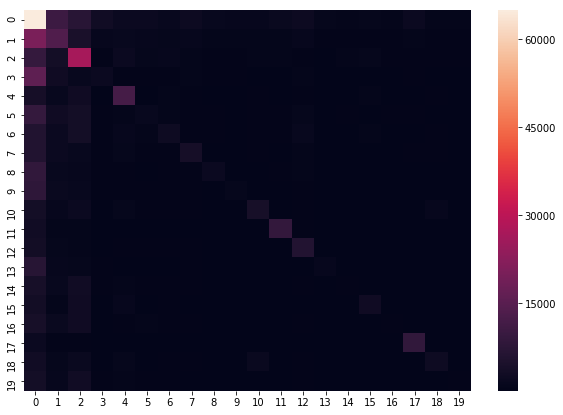

In [32]:
df_cm = pd.DataFrame(conf_mat, index = [i for i in set(eng_labels)], columns = [i for i in set(eng_labels)])
plt.figure(figsize= (10,7))
sn.heatmap(df_cm, annot=False)

In [33]:
print(classification_report(eng_labels, y_pred))

             precision    recall  f1-score   support

          0       0.35      0.61      0.44    106466
          1       0.26      0.26      0.26     51327
          2       0.38      0.53      0.44     50437
          3       0.16      0.07      0.10     27067
          4       0.44      0.48      0.46     24426
          5       0.14      0.06      0.09     23112
          6       0.20      0.12      0.15     21118
          7       0.28      0.21      0.24     18162
          8       0.25      0.11      0.15     16846
          9       0.17      0.06      0.08     15985
         10       0.33      0.24      0.28     15947
         11       0.55      0.58      0.56     15182
         12       0.35      0.43      0.39     13717
         13       0.28      0.10      0.14     12839
         14       0.11      0.04      0.06     13359
         15       0.30      0.20      0.24     13264
         16       0.11      0.04      0.06     12958
         17       0.56      0.67      0.61   

## Spanish Support Vector Machine Model

In [ ]:
pipe = Pipeline([('tfidf', TfidfVectorizer()),
                 ('clf', LinearSVC())])
scores = cross_val_score(pipe, esp_text, esp_labels, cv=5, n_jobs=-1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [ ]:
print(scores)

### Spanish Support Vector Machine Confusion Matrix

In [ ]:
y_pred = cross_val_predict(pipe,esp_text,esp_labels,cv=5, n_jobs=-1)
conf_mat = confusion_matrix(esp_labels,y_pred)
print(conf_mat)

In [ ]:
df_cm = pd.DataFrame(conf_mat, index = [i for i in set(esp_labels)], columns = [i for i in set(esp_labels)])
plt.figure(figsize= (10,7))
sn.heatmap(df_cm, annot=False)

In [ ]:
print(classification_report(esp_labels, y_pred))